# Fundamental Analysis 02

In [12]:
import pandas as pd


from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

from time import sleep

import re

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") 

In [13]:
BANK_SCRIPS = ['HDFCBANK','ICICIBANK','AXISBANK','KOTAKBANK','SBIN','CANBK']
IT_SCRIPS = ['INFY', 'HCLTECH', 'LTI', 'TCS','LTTS', 'WIPRO' ]
SCRIPS = IT_SCRIPS

In [32]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

SCRIP = 'INFY'
link = f'https://www.screener.in/company/{SCRIP}'
hdr = {'User-Agent':'Mozilla/5.0'}
req = Request(link,headers=hdr)
 
try:
    page=urlopen(req)
    soup = BeautifulSoup(page)
    
    div_html = soup.find('div',{'class': 'company-ratios'})
    ul_html = div_html.find('ul',{'id': 'top-ratios'})
    market_cap = 0.0
        
    for li in ul_html.find_all("li"):
        name_span = li.find('span',{'class':'name'})
        if 'Market Cap' in name_span.text: 
            num_span = li.find('span',{'class':'number'})
            num_span = num_span.text.replace(',', '')
            market_cap = float(num_span) if (num_span != '') else 0.0
            break
    
    print(f'MARKET CAPITILIZATION - {SCRIP}: {market_cap} Cr')

except:
    print(f'EXCEPTION THROWN: UNABLE TO FETCH DATA FOR {SCRIP}')

MARKET CAPITILIZATION - INFY: 1642.0 Cr


In [36]:
def extract_table_by_class(soup, section_id, class_name):
    section_html = soup.find('section',{'id': section_id})
    table_html = section_html.find('table',{'class': class_name})

    headers = []
    for header in table_html.find_all('th'):
        headers.append(  header.text or 'Type')

    table_df = pd.DataFrame(columns = headers)

    for row_element in table_html.find_all('tr')[1:]:
            row_data = row_element.find_all('td')
            row = [tr.text.strip() for tr in row_data]
            length = len(table_df)
            table_df.loc[length] = row 
            
    return table_df
    

def fetch_number_span(list_element):
    num_span = list_element.find('span',{'class':'number'})

    num_span = num_span.text.replace(',', '')
    return float(num_span) if (num_span != '') else 0.0
    
def extract_scrip_ratios(soup,div_class, ul_id):
    div_html = soup.find('div',{'class': div_class})
    ul_html = div_html.find('ul',{'id': ul_id})
    current_price = 0
    high = 0.0
    low = 0.0
    dividend_yield = 0.0
    pe = 0.0
    roe = 0.0
    roce = 0.0
    market_cap = 0.0
     
    scrip_data = pd.Series()
    
    for li in ul_html.find_all("li"):
        name_span = li.find('span',{'class':'name'})
        
        if 'Current Price' in name_span.text: 
            current_price = fetch_number_span(li)

        if 'High / Low' in name_span.text:
            num_spans = li.find_all('span',{'class':'number'})
            if(len(num_spans) == 2):
                high_num = num_spans[0].text.replace(',', '')
                low_num = num_spans[1].text.replace(',', '')
                high = float(high_num) if (high_num != '') else 0.0
                low = float(low_num) if (low_num != '') else 0.0 
                
        if 'Market Cap' in name_span.text: 
            market_cap = fetch_number_span(li)
            
        if 'Stock P/E' in name_span.text:
            pe = fetch_number_span(li) 
            
        if 'Dividend Yield' in name_span.text:
            dividend_yield = fetch_number_span(li) 
            
        if 'ROCE' in name_span.text:
            roce = fetch_number_span(li) 
            
        if 'ROE' in name_span.text:
            roe = fetch_number_span(li) 
            
    scrip_data['Current Price'] = current_price
    scrip_data['High'] = high
    scrip_data['Low'] = low
    scrip_data['Market_Cap'] = market_cap
    scrip_data['PE'] = pe
    scrip_data['Dividend'] = dividend_yield
    scrip_data['ROCE'] = roce
    scrip_data['ROE'] = roe
    return scrip_data


BASE_URL = 'https://www.screener.in/company/'
def fetch_scrip_data(scrip):
    link = f'{BASE_URL}{scrip}'
    hdr = {'User-Agent':'Mozilla/5.0'}
    req = Request(link,headers=hdr)
    
    profit_loss_df = None
    scrip_data = pd.Series()
    try:
        page=urlopen(req)
        soup = BeautifulSoup(page)
        scrip_data = extract_scrip_ratios(soup,'company-ratios', 'top-ratios')
        profit_loss_df = extract_table_by_class(soup, 'profit-loss', 'data-table responsive-text-nowrap')
    except:
        print(f'EXCEPTION THROWN: UNABLE TO FETCH DATA')

    return scrip_data, profit_loss_df
print(scrip_data)
 

     

def extract_last_n_years_pl(pl_df, n_years):
    # Extract data for all years from the column names
    mon_year_regex = re.compile('([A-Z][a-z]{2}) (\d{4})')
    years = {}
    for col in list(pl_df.columns):
        res = re.search(mon_year_regex,col)
        if res:
            years[res.group(2)] = col

    # Get only the last n (PROFIT_LOSS_YEARS) years for checking the P&L 
    years_list = sorted(years.keys())
    years_list = years_list[-n_years:]
    cols = [years[year] for year in years_list]
    pl_values = pl_df[cols].iloc[0, :].values.tolist()
    pl_values = [float(x.replace(',', '')) for x in pl_values] 
    return pl_values

Series([], dtype: object)


### CHECK IF CURRENT PRICE IS BELOW PREVIOUS HIGH


In [26]:
# Check if current price is below the 52-week high with a certain threshold
# Eg: If current price is 100, 52-week high is 120, threshold is 10%, then return True
#     If current price is 100, 52-week high is 105, threshold is 10%, then return False
def check_current_below_high_threshold(current,high, threshold_percent):
    below_threshold = False
    if ((current < high) & ((high-current)/high*100 > threshold_percent)):
        below_threshold = True
    return below_threshold   

### PROFIT/LOSS BASED STRATEGY
**STRATEGY:
BUY recommendation if:
1. Net profit for the company has been increasing consistently in the last few (config) years
2. Current market price is atleast 10% below the 52-week high (stock is not trading around all time high)

In [27]:
# PROFIT-LOSS STRATEGY - CONFIG
PROFIT_LOSS_YEARS = 3
SCREENER_ROW_PL = 'Net Profit' # or can be 'Profit before tax'
CURRENT_HIGH_THRESHOLD_PERCENT = 10

In [28]:
def apply_pl_strategy(current_price, scrip_high, profit_loss_df, high_threshold_percent):
    # SET DEFAULT TO STOCK AS NO-ACTION
    strategy_result = 'WAIT'
    try: 
        # CHECK IF REQUIRED VALUES COULD BE SCRAPED
        if (current_price is None or current_price == 0.0 or 
            scrip_high is None or scrip_high == 0.0):
            strategy_result = 'NOT FOUND'
        else:
            profit_loss_df = profit_loss_df[profit_loss_df['Type'] == SCREENER_ROW_PL]
            last_pl_list = extract_last_n_years_pl(profit_loss_df, PROFIT_LOSS_YEARS)
            print(f'Profit/Loss for last {PROFIT_LOSS_YEARS} years: {last_pl_list}')
            print(f'Current Price: {current_price}, 52-week High: {scrip_high}, Threshold%: {high_threshold_percent}%')

            # CHECK IF PROFIT-LOSS IS CONSISTENTLY INCREASING
            if last_pl_list == sorted(last_pl_list):
                # IF YES, CHECK IF CURRENT MARKET VALUE IS NOT AT ALL TIME HIGH
                if check_current_below_high_threshold(current_price, scrip_high, high_threshold_percent):
                    # BUY RECOMMENDATION
                    strategy_result = 'BUY'
    except Exception as e:
        print(f"UNABLE TO APPLY PROFIT-LOSS STRATEGY. Exception: {e}")

    return strategy_result


## SCRAPE THE DATA


In [37]:
final_df = pd.DataFrame({'Symbol':SCRIPS},
                        columns=['Symbol','Market_Cap','Current Price','High','Low','PE','ROE','ROCE','Dividend','STRATEGY_PL']).set_index('Symbol')

print(final_df)

        Market_Cap Current Price High  Low   PE  ROE ROCE Dividend STRATEGY_PL
Symbol                                                                        
INFY           NaN           NaN  NaN  NaN  NaN  NaN  NaN      NaN         NaN
HCLTECH        NaN           NaN  NaN  NaN  NaN  NaN  NaN      NaN         NaN
LTI            NaN           NaN  NaN  NaN  NaN  NaN  NaN      NaN         NaN
TCS            NaN           NaN  NaN  NaN  NaN  NaN  NaN      NaN         NaN
LTTS           NaN           NaN  NaN  NaN  NaN  NaN  NaN      NaN         NaN
WIPRO          NaN           NaN  NaN  NaN  NaN  NaN  NaN      NaN         NaN


In [54]:
final_df = pd.DataFrame({'Symbol':SCRIPS},
                        columns=['Symbol','Market_Cap','Current Price','High','Low','PE','ROE','ROCE','Dividend','STRATEGY_PL']).set_index('Symbol')


# LOOP THROUGH EACH SCRIP
for scrip in SCRIPS:
    print(f"\nSYMBOL: {scrip}")
    scrip_data, profit_loss_df = fetch_scrip_data(scrip)
    
    for index, value in scrip_data.items():
        final_df[index][scrip] = value

    
    # for index, value in scrip_data.iteritems():
    #     final_df[index][scrip] = value

    strategy_result = apply_pl_strategy(scrip_data['Current Pr'], scrip_data['High'], profit_loss_df, CURRENT_HIGH_THRESHOLD_PERCENT)
    print(f"APPLYING PROFIT/LOSS STRATEGY ON {scrip}: {strategy_result}")
    final_df['STRATEGY_PL'][scrip] = strategy_result
    #sleep(2) # Add sleep if TOO MANY REQUESTS error (Error Code: 429) is thrown

#display(final_df)
print(final_df)


SYMBOL: INFY
UNABLE TO APPLY PROFIT-LOSS STRATEGY. Exception: single positional indexer is out-of-bounds
APPLYING PROFIT/LOSS STRATEGY ON INFY: WAIT

SYMBOL: HCLTECH
UNABLE TO APPLY PROFIT-LOSS STRATEGY. Exception: single positional indexer is out-of-bounds
APPLYING PROFIT/LOSS STRATEGY ON HCLTECH: WAIT

SYMBOL: LTI
EXCEPTION THROWN: UNABLE TO FETCH DATA


KeyError: 'PE'

In [21]:
import pandas as pd

# Creating a pandas Series
data = {'a': 1, 'b': 2, 'c': 3}
series = pd.Series(data)

# Attempting to use iteritems() on a Series
# for index, value in series.iteritems():
#     print(index, value)

# Iterating directly over the Series
for value in series:
    print(value)

# Using iterrows() for DataFrame
df = pd.DataFrame({'column_name': series})
for index, row in df.iterrows():
    print(index, row['column_name'])


1
2
3
a 1
b 2
c 3


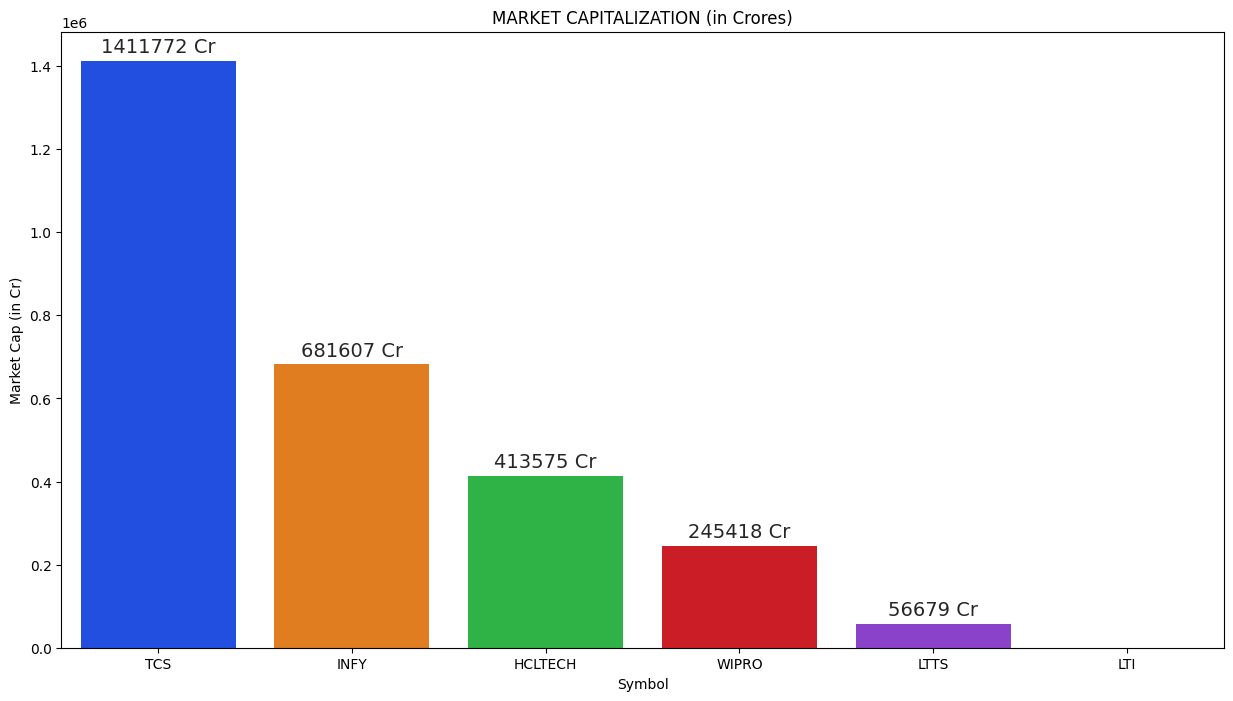

In [42]:
plt.figure(figsize = (15,8))

mark_cap_sorted_df = final_df.sort_values(by='Market_Cap', ascending = False)
ax = sns.barplot(x=mark_cap_sorted_df.index, y=mark_cap_sorted_df['Market_Cap'], palette = 'bright')
ax.set(xlabel="Symbol", ylabel='Market Cap (in Cr)',title = f'MARKET CAPITALIZATION (in Crores)') 
sns.set(font_scale = 1.5)

#annotate axis = seaborn axis
for p in ax.patches:
     ax.annotate("%.0f Cr" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=14,  xytext=(0, 10),
         textcoords='offset points')

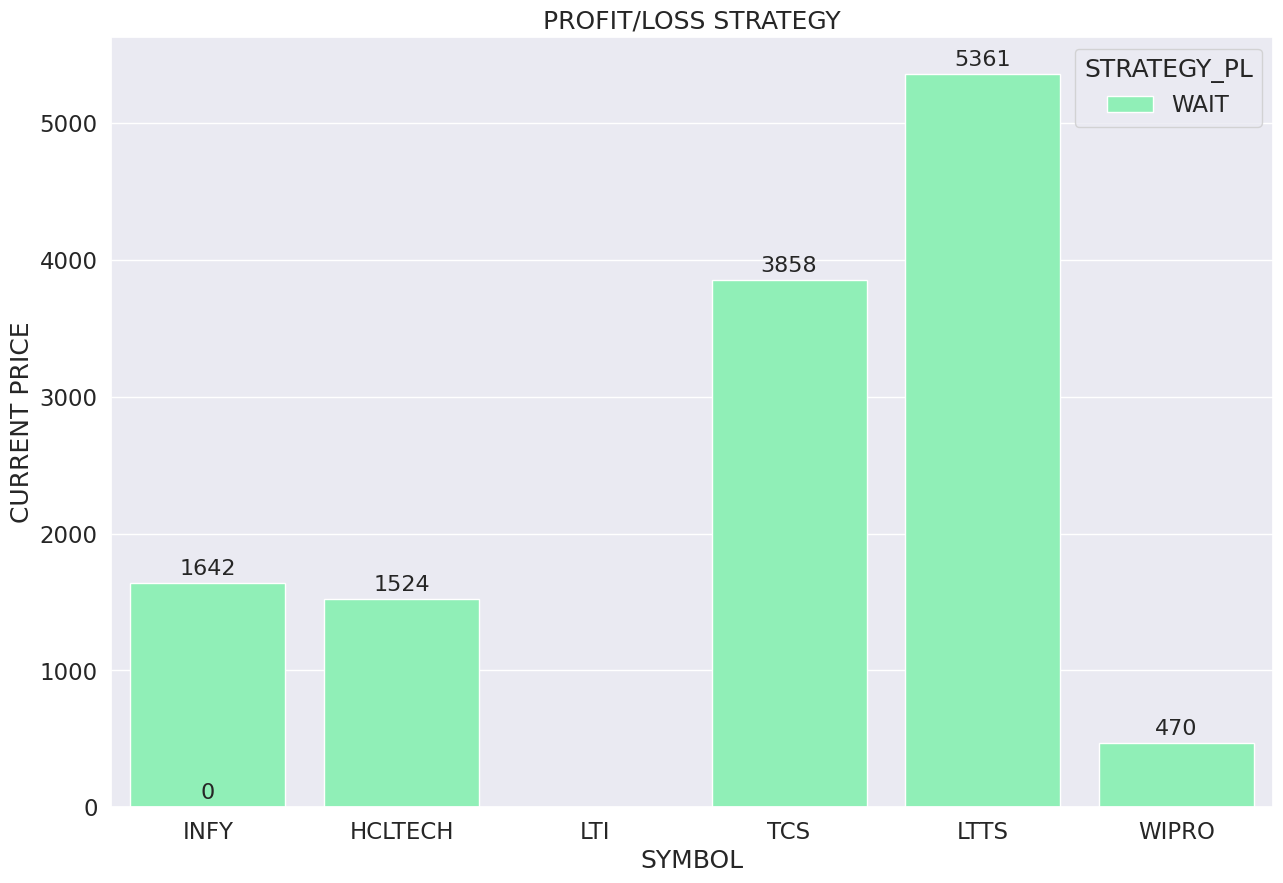

In [49]:
fig = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=final_df.index,y=final_df['Current Price'],hue=final_df['STRATEGY_PL'],palette='rainbow', dodge=False) 
ax.set(xlabel='SYMBOL', ylabel='CURRENT PRICE', title = 'PROFIT/LOSS STRATEGY')
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16,  xytext=(0, 10),
                 textcoords='offset points')

sns.set(font_scale = 1.5)
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

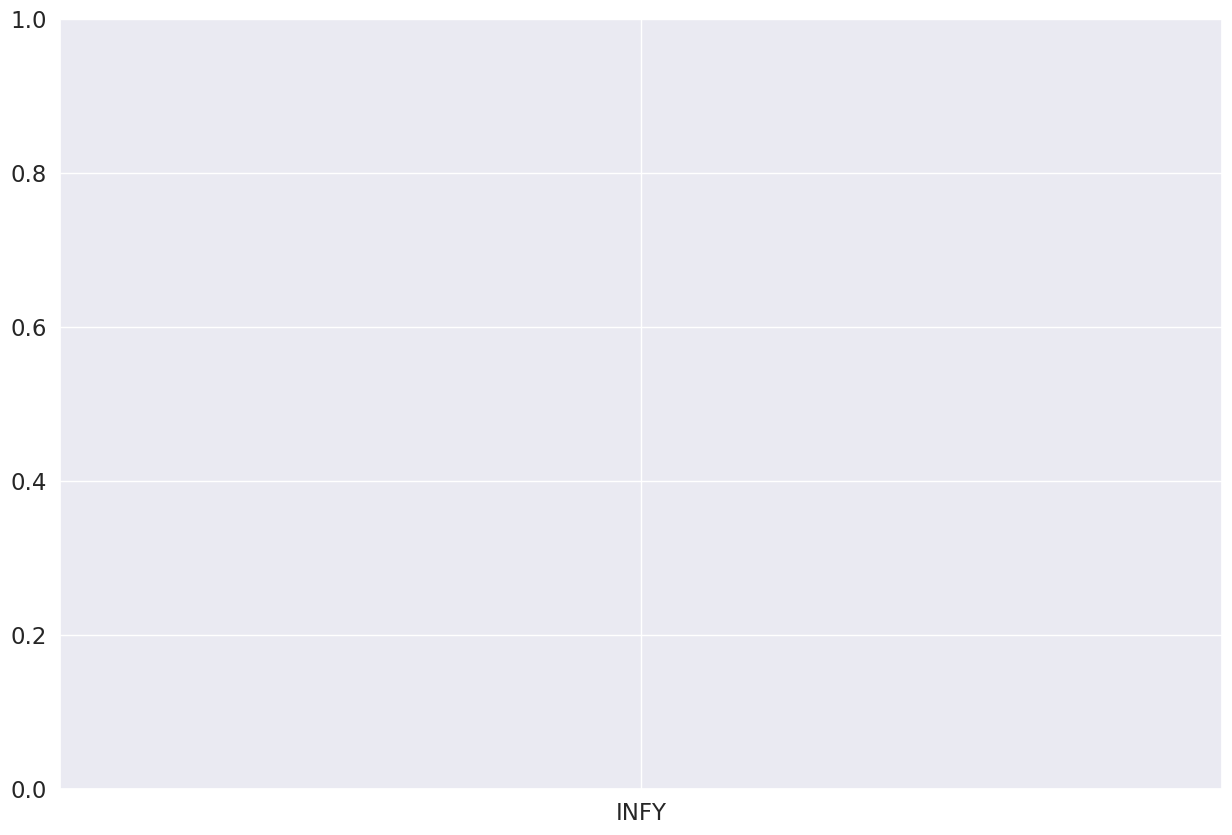

In [50]:
roe_data = pd.DataFrame(final_df['ROE']).rename(columns = {'ROE':'Value'})
roe_data['Type'] = 'ROE'

roce_data = pd.DataFrame(final_df['ROCE']).rename(columns = {'ROCE':'Value'})
roce_data['Type'] = 'ROCE'



pe_data = pd.DataFrame(final_df['PE']).rename(columns = {'PE':'Value'})
pe_data['Type'] = 'PE'

analysis_df = pd.concat([pe_data, roe_data,roce_data])
analysis_df

fig = plt.subplots(figsize=(15,10))

ax = sns.barplot(x=analysis_df.index,
           y=analysis_df['Value'],
           hue=analysis_df['Type'],
           palette = 'plasma')
ax.set( title = 'PE - ROE - ROCE COMPARISON')

for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16,  xytext=(0, 10),
                 textcoords='offset points')
        
plt.show()